In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import re

ruta_csv = "./CSVDATABASE.csv"

df_raw = pd.read_csv(ruta_csv, encoding="Windows-1252", sep=";", parse_dates=True)
# coger las filas donde la columna '        Heu llegit tota la informació que se us ha facilitat sobre aquest projecte i accepteu participar-hi?      ' es 'Sí'
df = df_raw[df_raw['        Heu llegit tota la informació que se us ha facilitat sobre aquest projecte i accepteu participar-hi?      '] == 'Sí']
useless_columns = ['Id', 'Language','        Heu llegit tota la informació que se us ha facilitat sobre aquest projecte i accepteu participar-hi?      ','Hora de inicio','Hora de finalización', 'Correo electrónico', 'Nombre']
cols_to_drop = [c for c in useless_columns if c in df.columns]
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
else:
    print("No matching columns to drop.")


# ============================================================
# LIMPIEZA PREVIA DE COLUMNAS: eliminar "Resposta", espacios,
# unicode raro, y dejar las Likert terminando en "." limpio
# ============================================================

clean_cols = []

for col in df.columns:
    new = col

    # 1. Normalizar espacios (colapsar espacios múltiples)
    new = " ".join(new.split())

    # 2. Limpiar caracteres invisibles
    new = new.replace("\xa0", " ")
    new = new.replace("\x92", "'")
    new = new.replace("\n", " ")

    # 3. Si contiene "Resposta", eliminarlo por completo
    if "Resposta" in new:
        # Eliminar todo lo que aparezca después de la primera oración
        # Ejemplo: "xxx. .Resposta" → "xxx."
        new = new.split(".")[0].strip() + "."

    clean_cols.append(new)

df.columns = clean_cols


#MAPPING DE LES PREGUNTES

column_map = {
    "Edat en anys en el moment de l'enquesta": "edat",
    "Sexe assignat al néixer": "sexe_assignat",
    "Gènere": "genere",
    "País de naixement": "pais_naixement",
    "Curs acadèmic actual": "curs",
    "Assignació mensual aproximada en euros (diners dels que disposes mensualment)": "assignacio_mensual",
    
    "Quin tipus de substàncies has consumit en els darrers 30 dies? (pots marcar més d’una)": "subs_30dies",
    "Coneixes la diferència entre els productes de tabac per escalfament (tipus IQOS) i les cigarretes electròniques (vàpers)?": "coneix_diferencia_iqos_vaper",
    "Quina és la teva història de fumador/a? (Qualsevol   tipus de consum, inclòs el tabac convencional, cigarreta electrònica i altres   productes de tabac)       ": "historia_fumador",
    
    "Quants minuts després de despertar-te fumes la primera cigarreta?      \n": "primera_cigarreta_minuts",
    "Quantes cigarretes fumes al dia?      ": "cigarretes_dia",
    "En quins àmbits consumeixes habitualment? (pots marcar més d’una opció)": "ambits_consum",
    
    "A quina edat vas començar a fumar cigarretes convencionals? (Si no n'has fumat escriu \"mai\")": "edat_inici_conventional",
    "A quina edat vas començar a consumir cigarretes electròniques (vàper)? (Si no n'has fumat escriu \"mai\")": "edat_inici_vaper",
    "A quina edat vas començar a consumir IQOS (tabac escalfat)? (Si no n'has fumat escriu \"mai\")": "edat_inici_iqos",
    
    "Quin va ser el motiu principal per començar a consumir cigarretes electròniques (vàper)? (pots marcar més d'una)      ": "motiu_inici_vaper",
    "Quin va ser el motiu principal per començar a consumir IQOS (tabac escalfat)? (pots marcar més d'una)      ": "motiu_inici_iqos",

    "Les dues persones amb qui tens més relació a la universitat fumen o vapegen?      ": "amics_fumen",
    "Aquestes persones...?      ": "influencia_amics",

    # ---- Escala Likert ----
    "Les cigarretes electròniques són fàcils d’adquirir.": 
        "likert_facil_adquirir",

    "El seu preu és assequible per a la majoria dels joves.": 
        "likert_preu_assequible",

    "Vapejar està socialment ben vist.": 
        "likert_social",

    "Considero que és normal veure companys vapejant en espais universitaris o socials.": 
        "likert_normal_vapejar",

    "Crec que les cigarretes electròniques són segures per a la salut.": 
        "likert_seguretat",

    "Les considero menys perjudicials que el tabac convencional.": 
        "likert_menys_perjudicials",

    "No hi ha prou estudis sobre els efectes adversos del vaping.": 
        "likert_pocs_estudis",

    "El vapor de les cigarretes electròniques no afecta a tercers.": 
        "likert_no_afecta_tercers",

    "S’hauria de limitar l’accés a menors.": 
        "likert_limit_menors",

    "Caldria un control més estricte de la seva venta.": 
        "likert_control_estricte",

    "Els sabors haurien d’estar regulats.": 
        "likert_regulacio_sabors",

    "Haurien d’estar prohibits en espais tancats.": 
        "likert_prohibicio_espais_tancats",

    "S’hauria de prohibir la seva publicitat en xarxes socials.": 
        "likert_prohibicio_publicitat",

    "Només s’haurien de vendre en punts autoritzats.": 
        "likert_punts_autoritzats",

    "Haurien de portar advertències sanitàries com el tabac.": 
        "likert_advertencies",

    "Les cigarretes electròniques poden portar a fumar cigarretes convencionals.": 
        "likert_electronic_induccio_tabac"
}

df.rename(columns=column_map, inplace=True)

# Normalización extra para columnas con "mai"
corr_map = {
    col: "edat_inici_vaper" 
    for col in df.columns 
    if "a quina edat vas començar a consumir cigarretes electròniques" in col.lower()
}

corr_map.update({
    col: "influencia_amics" 
    for col in df.columns 
    if "aquestes persones..." in col.lower()
})

corr_map.update({
    col: "cigarretes_dia" 
    for col in df.columns 
    if "quantes cigarretes fumes al dia" in col.lower()
})

corr_map.update({
    col: "amics_fumen" 
    for col in df.columns 
    if "les dues persones amb qui tens més relació a la universitat fumen o vapegen?" in col.lower()
})

corr_map.update({
    col: "edat_inici_iqos" 
    for col in df.columns 
    if "quina edat vas començar a consumir IQOS (tabac escalfat)" in col.lower()
})

corr_map.update({
    col: "primera_cigarreta_minuts" 
    for col in df.columns 
    if "minuts després de despertar-te fumes la primera cigarreta" in col.lower()
})

corr_map.update({
    col: "historia_fumador" 
    for col in df.columns 
    if "uina és la teva història de fumador" in col.lower()
})

corr_map.update({
    col: "motiu_inici_vaper" 
    for col in df.columns 
    if "uin va ser el motiu principal per començar a consumir cigarretes electròniques" in col.lower()
})

corr_map.update({
    col: "motiu_inici_iqos" 
    for col in df.columns 
    if "motiu principal per començar a consumir iqos" in col.lower()
})


df = df.rename(columns=corr_map)

likert_map = {
    "totalment en desacord": 1,
    "totalment en desacord": 1,
    "        totalment en desacord": 1,
    "en desacord ": 2,
    "en desacord": 2,
    "en desacord ": 2,
    "ni d’acord ni en desacord ": 3,
    "ni d’acord ni en desacord": 3,
    "ni d'acord ni en desacord": 3,
    "d’acord": 4,
    "d'acord": 4,
    "totalment d’acord": 5,
    "totalment d'acord": 5,
    "totalment d’acord": 5
}

likert_columns = [
 'likert_facil_adquirir',
 'likert_preu_assequible',
 'likert_social',
 'likert_normal_vapejar',
 'likert_seguretat',
 'likert_menys_perjudicials',
 'likert_pocs_estudis',
 'likert_no_afecta_tercers',
 'likert_limit_menors',
 'likert_control_estricte',
 'likert_regulacio_sabors',
 'likert_prohibicio_espais_tancats',
 'likert_prohibicio_publicitat',
 'likert_punts_autoritzats',
 'likert_advertencies',
 'likert_electronic_induccio_tabac'
]

for col in likert_columns:
    if col in df.columns:
        df[col] = df[col].map(likert_map)

def clean_assignacio(value):

    if pd.isna(value):
        return np.nan
    
    text = str(value).strip().lower()

    # --- CASOS QUE SON CERO ---
    zero_patterns = [
        "no em donen cap assignació",
        "no tinc una quantitat definida",
        "no treballo",
        "no",
        "pares paguen",
        "visc amb els meus pares", 
        "0", "0€", "0 euros", "0.0"
    ]
    for z in zero_patterns:
        if text.startswith(z):
            return 0

    # --- ELIMINAR SIMBOLOS Y ESPACIOS ---
    text = text.replace("€", "").replace("euros", "").replace("euro", "").strip()

    # --- RANGOS  ej: 90-100, 200-400 ---
    range_match = re.match(r"(\d+)\s*-\s*(\d+)", text)
    if range_match:
        low = int(range_match.group(1))
        high = int(range_match.group(2))
        return (low + high) / 2  # media del rango

    # --- NÚMEROS PUROS ---
    num_match = re.findall(r"\d+", text)
    if num_match:
        return float(num_match[0])

    # --- CASO NO INTERPRETABLE ---
    return np.nan

preguntes_fumadors = ["primera_cigarreta_minuts", "cigarretes_dia", "ambits_consum", "edat_inici_conventional", "edat_inici_vaper", "edat_inici_iqos", "motiu_inici_vaper", "motiu_inici_iqos"]

# Aplicar la función a la columna
df["assignacio_mensual"] = df["assignacio_mensual"].apply(clean_assignacio)


# GESTIÓ DE SUBSTÀNCIES CONSUMIDES EN ELS DARRERS 30 DIES
# Primero limpiamos: quitar espacios dobles y dividir por ";"
df["substancies_clean"] = (
    df["subs_30dies"]
    .fillna("")
    .str.split(";")
    .apply(lambda items: [x.strip() for x in items if x.strip() != ""])
)

all_substances = sorted({s for lista in df["substancies_clean"] for s in lista})

for substance in all_substances:
    df[f"consum_{substance}"] = df["substancies_clean"].apply(
        lambda lista: 1 if substance in lista else 0
    )

df = df.drop(columns=["substancies_clean"])

df = pd.get_dummies(df, columns=["historia_fumador"], prefix="historia_fumador", dtype=int)

df = pd.get_dummies(df, columns=["influencia_amics"], prefix="influencia_amics", dtype=int)

df.rename(columns={
    'historia_fumador_He fumat, però actualment no ': 'exfumador',
    'historia_fumador_No he fumat mai ': 'no_fumador',
    'historia_fumador_Soc fumador/a': 'fumador'
}, inplace=True)


def limpiar_edad_inicio(valor):
    if pd.isna(valor):
        return np.nan

    v = str(valor).lower().strip()

    # 1. Respuestas que indican NO consumo -> NaN
    if v in ["mai", "no", "mai ", "mai.", "mai fumo"]:
        return np.nan
    
    # 2. Extraer números del texto
    numeros = re.findall(r"\d+", v)

    if len(numeros) == 0:
        return np.nan
    
    # Convertir a enteros
    nums = [int(n) for n in numeros]

    # 3. Si hay dos números (ej: 16-17, 14/15, 16 o 17) -> media
    if len(nums) >= 2:
        edad = np.mean(nums)
    else:
        edad = nums[0]

    # 4. Si edad detectada es 4 -> NaN
    if edad == 4:
        return np.nan

    return edad

# Crear la nueva columna
df["edat_inici_conventional"] = df["edat_inici_conventional"].apply(limpiar_edad_inicio)
df["edat_inici_vaper"] = df["edat_inici_vaper"].apply(limpiar_edad_inicio)
df["edat_inici_iqos"] = df["edat_inici_iqos"].apply(limpiar_edad_inicio)




C:\Users\druiz\AppData\Local\Temp\ipykernel_21232\3179536501.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=cols_to_drop, inplace=True)
C:\Users\druiz\AppData\Local\Temp\ipykernel_21232\3179536501.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=column_map, inplace=True)


**EDA (EXPLORATORY DATA ANALYSIS)**

In [2]:
import pandas as pd
import numpy as np

# ================================================
# 1. NORMALIZACIÓN DE CATEGORÍAS
# ================================================

# --- Normalizar género ---
df["genere"] = (
    df["genere"]
    .str.strip()
    .str.lower()
    .replace({
        "femení": "Femení",
        "femení ": "Femení",
        "femení": "Femení",
        "femeni": "Femení",
        "femení": "Femení",
        "masculí": "Masculí",
        "masculi": "Masculí",
        "no-binari": "No-binari",
        "no binari": "No-binari",
    })
)

# --- Normalizar sexe_assignat ---
df["sexe_assignat"] = (
    df["sexe_assignat"]
    .str.strip()
    .str.lower()
    .replace({
        "dona": "Dona",
        "home": "Home"
    })
)

# --- Normalizar país de nacimiento ---
df["pais_naixement"] = (
    df["pais_naixement"]
    .str.strip()
    .str.lower()
    .replace({
        "espanya": "Espanya",
        "marroc": "Marroc",
        "veneçuela": "Veneçuela",
        "venezuela": "Veneçuela",
        "frança": "França",
        "france": "França",
        "colombia": "Colòmbia",
        "peru": "Perú",
        "andorra": "Andorra",
        "italia": "Itàlia",
        "pakistan": "Pakistan",
        "suècia": "Suècia",
        "suecia": "Suècia",
        "portugal": "Portugal",
        "belgica": "Bèlgica",
        "argelia": "Algèria",
        "russia": "Rússia",
        "xina": "Xina",
        "china": "Xina",
    })
)

# Pasar a capitalización correcta
df["pais_naixement"] = df["pais_naixement"].str.capitalize()



# Función para formatear n (%) como en artículos científicos
def format_n_pct(series):
    total = len(series.dropna())
    return [f"{count} ({count/total*100:.1f})" for count in series.value_counts()]


# === ORDEN REAL DE TUS CURSOS EXACTAMENTE COMO APARECEN ===
orden_cursos = ["1r", "2n", "3r", "4t", "5è", "6è"]


# Diccionario de variables
variables = {
    "sexe_assignat": "Sexe assignat al néixer",
    "genere": "Gènere",
    "pais_naixement": "País de naixement",
    "curs": "Curs acadèmic",
}


rows = []
index_labels = []

for var, title in variables.items():
    
    # Título de grupo
    rows.append(["", ""])
    index_labels.append(title.upper())
    
    # ----------------------------------------
    # ORDEN ESPECIAL PARA NACIONALIDAD
    # ----------------------------------------
    if var == "pais_naixement":
        vc = df[var].value_counts()  # más común → menos común
        formatted = format_n_pct(df[var])
    
    # ----------------------------------------
    # ORDEN ESPECIAL PARA CURS ACADÈMIC
    # ----------------------------------------
    elif var == "curs":
        cursos = df[var].dropna().astype(str)

        # Value counts
        vc = cursos.value_counts()

        # Reordenamos según tu orden exacto
        ordenados = [curso for curso in orden_cursos if curso in vc.index]
        vc = vc[ordenados]

        # Recalcular n (%) en ese orden
        formatted = [f"{vc[c]} ({vc[c] / vc.sum() * 100:.1f})" for c in vc.index]
    
    # ----------------------------------------
    # VARIABLES NORMALES
    # ----------------------------------------
    else:
        vc = df[var].value_counts(sort=False)
        formatted = format_n_pct(df[var])
    
    # Añadir filas
    for cat, val in zip(vc.index, formatted):
        rows.append([cat, val])
        index_labels.append("")


# Crear tabla final
table = pd.DataFrame(rows, columns=["Characteristic", "n (%)"])
table.index = index_labels

table


,Characteristic,n (%)
SEXE ASSIGNAT AL NÉIXER,,
,Dona,301 (70.8)
,Home,124 (29.2)
GÈNERE,,
,Femení,301 (70.8)
,Masculí,122 (28.7)
,No-binari,2 (0.5)
PAÍS DE NAIXEMENT,,
,Espanya,383 (90.1)
,Veneçuela,5 (1.2)


In [3]:
from IPython.display import display as _orig_display

# Invertir el mapeo original para recuperar las preguntas antes del rename
invert_map = {v: k for k, v in column_map.items()}

# Variables numéricas
cols = ["edat", "assignacio_mensual"]

# Calcular estadísticas
summary = df[cols].agg(["count", "mean", "median", "std", "min", "max"]).T

# Añadir valores faltantes
summary["missing"] = df[cols].isna().sum()

# Reordenar columnas y redondear
summary = summary[["count", "missing", "mean", "median", "std", "min", "max"]]
summary = summary.round({"mean": 2, "median": 2, "std": 2, "min": 2, "max": 2})

# Crear DataFrame con variable original
summary_with_pregunta = summary.reset_index().rename(columns={"index": "variable"})

# Mapear a nombre original (si no existe en el diccionario, se deja el corto)
summary_with_pregunta["pregunta"] = summary_with_pregunta["variable"].map(invert_map).fillna(summary_with_pregunta["variable"])

# Reordenar columnas: primero "pregunta", luego resto
cols_order = ["pregunta"] + [c for c in summary_with_pregunta.columns if c not in ["pregunta"]]
summary_with_pregunta = summary_with_pregunta[cols_order]

display(summary_with_pregunta)


,pregunta,variable,count,missing,mean,median,std,min,max
0,Edat en anys en el moment de l'enquesta,edat,425.0,0,20.84,20.0,3.70,16.0,54.0
1,Assignació mensual aproximada en euros (diners...,assignacio_mensual,409.0,16,338.61,200.0,494.23,0.0,4200.0


ShapiroResult(statistic=0.6021279526022304, pvalue=1.3966280616512155e-29)


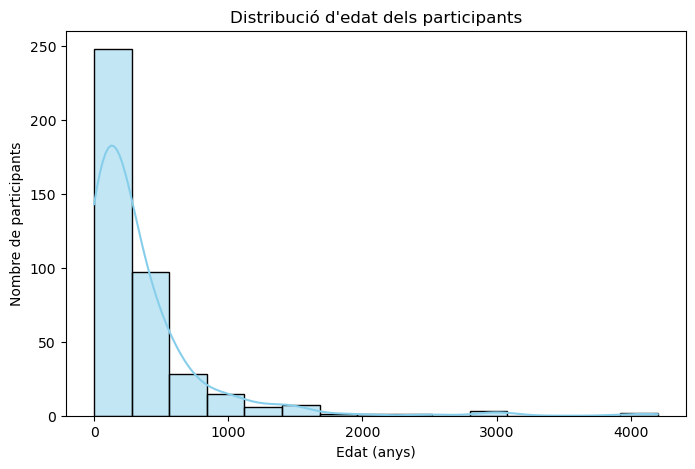

In [4]:
# plot per la distribució d'edat
print(stats.shapiro(df["assignacio_mensual"].dropna()))

plt.figure(figsize=(8, 5))
sns.histplot(df["assignacio_mensual"].dropna(), bins=15, kde=True, color="skyblue")
plt.title("Distribució d'edat dels participants")
plt.xlabel("Edat (anys)")
plt.ylabel("Nombre de participants")
plt.show()


ShapiroResult(statistic=0.7118240785618762, pvalue=2.147172188819563e-26)


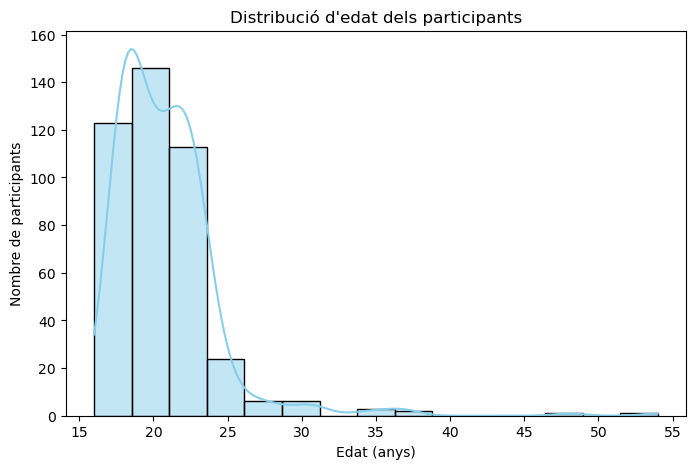

In [5]:
# plot per la distribució d'edat
print(stats.shapiro(df["edat"].dropna()))
plt.figure(figsize=(8, 5))
sns.histplot(df["edat"].dropna(), bins=15, kde=True, color="skyblue")
plt.title("Distribució d'edat dels participants")
plt.xlabel("Edat (anys)")
plt.ylabel("Nombre de participants")
plt.show()

***PREGUNTES LIKERT***

In [6]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# Columns to include
numeric_cols = [c for c in ["edat", "assignacio_mensual"] + likert_columns if c in df.columns]

# Convert to numeric
df_num = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Correlation matrix
corr = df_num.corr(method="pearson")

# -----------------------------
# BUILD ANNOTATION MATRIX (ONLY r, NO STARS)
# -----------------------------
annot_r = corr.round(2).astype(str)

# -----------------------------
# Compute p-values
# -----------------------------
pvals = pd.DataFrame(
    np.ones((len(numeric_cols), len(numeric_cols))),
    index=numeric_cols, columns=numeric_cols
)

for i, col_i in enumerate(numeric_cols):
    for j, col_j in enumerate(numeric_cols):
        if j <= i:
            continue
        paired = df_num[[col_i, col_j]].dropna()
        if len(paired) > 2:
            _, p = pearsonr(paired.iloc[:, 0], paired.iloc[:, 1])
            pvals.loc[col_i, col_j] = p
            pvals.loc[col_j, col_i] = p
        else:
            pvals.loc[col_i, col_j] = np.nan
            pvals.loc[col_j, col_i] = np.nan

# -----------------------------
# DISPLAY TABLES
# -----------------------------
print("📌 MATRIZ DE CORRELACIONES (r)")
display(corr.round(3))

print("📌 MATRIZ DE P-VALUES")
display(pvals.round(4))



📌 MATRIZ DE CORRELACIONES (r)


,edat,assignacio_mensual,likert_facil_adquirir,likert_preu_assequible,likert_social,likert_normal_vapejar,likert_seguretat,likert_menys_perjudicials,likert_pocs_estudis,likert_no_afecta_tercers,likert_limit_menors,likert_control_estricte,likert_regulacio_sabors,likert_prohibicio_espais_tancats,likert_prohibicio_publicitat,likert_punts_autoritzats,likert_advertencies,likert_electronic_induccio_tabac
edat,1.000,0.488,-0.080,-0.034,-0.065,-0.131,0.105,-0.011,-0.035,-0.019,0.018,-0.036,0.073,0.071,0.066,0.009,0.002,-0.024
assignacio_mensual,0.488,1.000,-0.042,0.109,-0.035,-0.003,0.080,0.098,-0.014,0.061,-0.048,-0.052,0.018,-0.062,-0.008,0.002,-0.049,0.065
likert_facil_adquirir,-0.080,-0.042,1.000,0.329,0.188,0.103,-0.022,0.015,0.178,-0.043,0.191,0.222,0.143,0.076,0.106,0.170,0.198,0.154
likert_preu_assequible,-0.034,0.109,0.329,1.000,0.202,0.019,-0.074,0.067,0.092,0.003,0.144,0.174,0.099,0.067,0.062,0.080,0.076,0.136
likert_social,-0.065,-0.035,0.188,0.202,1.000,0.291,-0.005,-0.037,0.116,-0.014,0.138,0.145,0.009,0.085,0.093,0.136,0.126,0.060
likert_normal_vapejar,-0.131,-0.003,0.103,0.019,0.291,1.000,0.115,0.078,0.060,0.079,0.052,-0.001,-0.064,-0.043,-0.066,0.016,-0.039,0.045
likert_seguretat,0.105,0.080,-0.022,-0.074,-0.005,0.115,1.000,0.250,0.027,0.255,-0.285,-0.310,-0.135,-0.211,-0.163,-0.226,-0.214,-0.122
likert_menys_perjudicials,-0.011,0.098,0.015,0.067,-0.037,0.078,0.250,1.000,0.105,0.228,-0.119,-0.156,-0.144,-0.100,-0.078,-0.109,-0.184,-0.053
likert_pocs_estudis,-0.035,-0.014,0.178,0.092,0.116,0.060,0.027,0.105,1.000,0.038,0.106,0.129,0.025,0.042,-0.016,0.115,0.061,0.144
likert_no_afecta_tercers,-0.019,0.061,-0.043,0.003,-0.014,0.079,0.255,0.228,0.038,1.000,-0.176,-0.210,-0.218,-0.250,-0.124,-0.116,-0.247,-0.137


📌 MATRIZ DE P-VALUES


,edat,assignacio_mensual,likert_facil_adquirir,likert_preu_assequible,likert_social,likert_normal_vapejar,likert_seguretat,likert_menys_perjudicials,likert_pocs_estudis,likert_no_afecta_tercers,likert_limit_menors,likert_control_estricte,likert_regulacio_sabors,likert_prohibicio_espais_tancats,likert_prohibicio_publicitat,likert_punts_autoritzats,likert_advertencies,likert_electronic_induccio_tabac
edat,1.0000,0.0000,0.0994,0.4863,0.1816,0.0067,0.0303,0.8157,0.4684,0.6912,0.7162,0.4536,0.1308,0.1438,0.1753,0.8573,0.9600,0.6205
assignacio_mensual,0.0000,1.0000,0.3955,0.0274,0.4773,0.9439,0.1068,0.0465,0.7752,0.2180,0.3323,0.2917,0.7205,0.2113,0.8647,0.9755,0.3190,0.1894
likert_facil_adquirir,0.0994,0.3955,1.0000,0.0000,0.0001,0.0329,0.6478,0.7645,0.0002,0.3725,0.0001,0.0000,0.0031,0.1170,0.0293,0.0004,0.0000,0.0015
likert_preu_assequible,0.4863,0.0274,0.0000,1.0000,0.0000,0.6971,0.1302,0.1702,0.0593,0.9522,0.0029,0.0003,0.0422,0.1660,0.2026,0.0997,0.1159,0.0050
likert_social,0.1816,0.4773,0.0001,0.0000,1.0000,0.0000,0.9138,0.4436,0.0164,0.7721,0.0043,0.0027,0.8499,0.0798,0.0550,0.0049,0.0095,0.2188
likert_normal_vapejar,0.0067,0.9439,0.0329,0.6971,0.0000,1.0000,0.0174,0.1078,0.2192,0.1019,0.2805,0.9819,0.1856,0.3730,0.1724,0.7351,0.4237,0.3541
likert_seguretat,0.0303,0.1068,0.6478,0.1302,0.9138,0.0174,1.0000,0.0000,0.5734,0.0000,0.0000,0.0000,0.0052,0.0000,0.0007,0.0000,0.0000,0.0116
likert_menys_perjudicials,0.8157,0.0465,0.7645,0.1702,0.4436,0.1078,0.0000,1.0000,0.0309,0.0000,0.0143,0.0012,0.0030,0.0389,0.1093,0.0246,0.0001,0.2786
likert_pocs_estudis,0.4684,0.7752,0.0002,0.0593,0.0164,0.2192,0.5734,0.0309,1.0000,0.4379,0.0282,0.0080,0.6016,0.3867,0.7472,0.0182,0.2076,0.0030
likert_no_afecta_tercers,0.6912,0.2180,0.3725,0.9522,0.7721,0.1019,0.0000,0.0000,0.4379,1.0000,0.0003,0.0000,0.0000,0.0000,0.0106,0.0165,0.0000,0.0046


*CORRELACION ENTRE SER FUMADOR/EXFUMADOR/NO FUMADOR Y VARIABLES COMO LA EDAD, EL SEXO, EL CURSO O LA ASIGNACION MENSUAL*

In [7]:
df["sexe_assignat"] = df["sexe_assignat"].map({
    "Home": 0,
    "Dona": 1
})

df["coneix_diferencia_iqos_vaper"] = df["coneix_diferencia_iqos_vaper"].map({
    "No": 0,
    "Sí": 1
})

df["curs"] = df["curs"].map({
    "1r": 1,
    "2n": 2,
    "3r": 3,
    "4t": 4,
    "5è": 5,
    "6è": 6
})

fumador_vars = ["fumador", "no_fumador", "exfumador"]
vars_cuant = ["edat", "sexe_assignat", "curs", "assignacio_mensual"]

# ------------------------------------------------------
# 3. CÁLCULO AUTOMÁTICO DE CORRELACIONES
# ------------------------------------------------------

resultados = []

for fum_var in fumador_vars:
    for v in vars_cuant:

        # Filtrar filas sin NaN
        df_temp = df[[fum_var, v]].dropna()

        if len(df_temp) < 2:  # no se puede correlacionar
            corr = np.nan
            p = np.nan
        else:
            corr, p = pearsonr(df_temp[fum_var], df_temp[v])

        resultados.append({
            "variable_fumador": fum_var,
            "variable_continua": v,
            "correlacion": corr,
            "p_valor": p
        })

# Convertir a DataFrame final
tabla_cor = pd.DataFrame(resultados).round(4)

# Mostrar tabla
tabla_cor

,variable_fumador,variable_continua,correlacion,p_valor
0,fumador,edat,-0.0043,0.9303
1,fumador,sexe_assignat,-0.0369,0.4475
2,fumador,curs,0.0629,0.1956
3,fumador,assignacio_mensual,0.1481,0.0027
4,no_fumador,edat,-0.0506,0.2978
5,no_fumador,sexe_assignat,0.0145,0.7649
6,no_fumador,curs,0.0041,0.9330
7,no_fumador,assignacio_mensual,-0.0858,0.0832
8,exfumador,edat,0.0587,0.2269
9,exfumador,sexe_assignat,0.0059,0.9033


In [8]:
tabla_cor = tabla_cor.sort_values(by=["p_valor"])
display(tabla_cor)

,variable_fumador,variable_continua,correlacion,p_valor
3,fumador,assignacio_mensual,0.1481,0.0027
7,no_fumador,assignacio_mensual,-0.0858,0.0832
2,fumador,curs,0.0629,0.1956
8,exfumador,edat,0.0587,0.2269
4,no_fumador,edat,-0.0506,0.2978
10,exfumador,curs,-0.0421,0.3865
1,fumador,sexe_assignat,-0.0369,0.4475
5,no_fumador,sexe_assignat,0.0145,0.7649
11,exfumador,assignacio_mensual,0.0092,0.8525
9,exfumador,sexe_assignat,0.0059,0.9033


*CORRELACION ENTRE SER FUMADOR/EXFUMADOR/NO FUMADOR CON TODAS LAS PREGUNTAS LIKERT*

In [9]:
fumador_vars = ["fumador", "no_fumador", "exfumador"]

resultados = []

for l_col in likert_columns:
    for f_col in fumador_vars:

        data = df[[l_col, f_col]].dropna()

        # Evitar errores si no hay datos suficientes
        if len(data) < 3:
            corr = np.nan
            p = np.nan
        else:
            corr, p = pearsonr(data[l_col], data[f_col])

        resultados.append({
            "likert": l_col,
            "variable_fumador": f_col,
            "correlacion_r": corr,
            "p_valor": p
        })

tabla_cor_likert = pd.DataFrame(resultados).round(4)

tabla_cor_likert.sort_values("p_valor")

,likert,variable_fumador,correlacion_r,p_valor
33,likert_prohibicio_espais_tancats,fumador,-0.1979,0.0000
34,likert_prohibicio_espais_tancats,no_fumador,0.2391,0.0000
35,likert_prohibicio_espais_tancats,exfumador,-0.1473,0.0023
25,likert_limit_menors,no_fumador,0.1263,0.0091
28,likert_control_estricte,no_fumador,0.1055,0.0297
9,likert_normal_vapejar,fumador,0.1037,0.0325
15,likert_menys_perjudicials,fumador,0.0933,0.0547
26,likert_limit_menors,exfumador,-0.0914,0.0599
6,likert_social,fumador,-0.0903,0.0630
19,likert_pocs_estudis,no_fumador,-0.0845,0.0818


*CORRELACION LIKERT CON PREGUNTA DEL CONOCIMIENTO DE DIFERENCIAS DEL TABACO Y EL VAPER*

In [10]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

binaria = "coneix_diferencia_iqos_vaper"

resultados = []

for col in likert_columns:

    datos = df[[col, binaria]].dropna()

    if len(datos) < 3:
        r = np.nan
        p = np.nan
    else:
        r, p = pearsonr(datos[col], datos[binaria])

    resultados.append({
        "likert": col,
        "correlacion_r": r,
        "p_valor": p
    })

tabla_cor_iqos = pd.DataFrame(resultados).round(4)

tabla_cor_iqos.sort_values("p_valor")



,likert,correlacion_r,p_valor
11,likert_prohibicio_espais_tancats,-0.1251,0.0098
0,likert_facil_adquirir,0.1189,0.0142
1,likert_preu_assequible,0.1118,0.0211
15,likert_electronic_induccio_tabac,0.1033,0.0333
3,likert_normal_vapejar,0.0787,0.1050
2,likert_social,-0.0670,0.1681
10,likert_regulacio_sabors,0.0422,0.3856
7,likert_no_afecta_tercers,0.0356,0.4641
5,likert_menys_perjudicials,-0.0254,0.6012
8,likert_limit_menors,-0.0210,0.6652


*FAGERSTROM Y CORRELACION CON LIKERT*

In [11]:
import numpy as np
import pandas as pd

# ---------------------------
# Mapeo para "primera_cigarreta_minuts"
# ---------------------------

map_primera = {
    '6-30 minuts': 2,
    '31-60 minuts': 1,
    ' Més de 60 minuts': 0,
    "No fumo": 0,
    "no fumo": 0
}

df["puntos_primera"] = df["primera_cigarreta_minuts"].map(map_primera)


# ---------------------------
# Mapeo para "cigarretes_dia"
# ---------------------------

map_cigs = {
    "10 o menys ": 0,
    "11-20 ": 1,
    "No fumo": 0,
    "no fumo": 0
}

df["puntos_dia"] = df["cigarretes_dia"].map(map_cigs)


# ---------------------------
# Puntuación total del Fagerström breve
# ---------------------------
df["fagerstrom"] = df["puntos_primera"] + df["puntos_dia"]

print(df["fagerstrom"].value_counts(dropna=False).sort_index())

# Correlacion entre fagerstrom y likert
resultados = []

for col in likert_columns:
    datos = df[[col, "fagerstrom"]].dropna()

    if len(datos) < 3:
        r = np.nan
        p = np.nan
    else:
        r, p = pearsonr(datos[col], datos["fagerstrom"])

    resultados.append({
        "likert": col,
        "correlacion_r": r,
        "p_valor": p
    })
tabla_cor_fagerstrom = pd.DataFrame(resultados).round(4)
tabla_cor_fagerstrom.sort_values("p_valor")
tabla_cor_fagerstrom
tabla_cor_fagerstrom.sort_values("p_valor")

fagerstrom
0.0     15
1.0      5
2.0      1
3.0      1
NaN    403
Name: count, dtype: int64


,likert,correlacion_r,p_valor
5,likert_menys_perjudicials,0.3620,0.0979
12,likert_prohibicio_publicitat,0.3538,0.1062
7,likert_no_afecta_tercers,0.2949,0.1828
2,likert_social,-0.2622,0.2385
8,likert_limit_menors,0.2537,0.2545
10,likert_regulacio_sabors,0.2486,0.2645
3,likert_normal_vapejar,-0.2100,0.3483
13,likert_punts_autoritzats,0.1991,0.3744
0,likert_facil_adquirir,-0.1396,0.5355
11,likert_prohibicio_espais_tancats,0.1247,0.5802


In [12]:
# Verificar cuantas personas no se han identificado como fumadores, pero en los ultimos 30 dias han probado el tabaco o el vaper
df_fumadores_30dias = df[
    (df["fumador"] == 0) & 
    (
        (df["consum_Tabac convencional"] == 1) | 
        (df["consum_Cigarretes electròniques"] == 1) | 
        (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1)
    )
]
print(f"Personas no identificadas como fumadores pero que han consumido tabaco o vaper en los últimos 30 días: {len(df_fumadores_30dias)}")

Personas no identificadas como fumadores pero que han consumido tabaco o vaper en los últimos 30 días: 49


In [13]:
# Verificar cuantas personas no se han identificado como fumadores, pero en los ultimos 30 dias han probado el tabaco o el vaper
df_fumadores_30dias = df[ 
        (df["consum_Tabac convencional"] == 1) | 
        (df["consum_Cigarretes electròniques"] == 1) | 
        (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1)
]
print(f"Personas que han fumado algo en los últimos trenta días: {len(df_fumadores_30dias)}")

Personas que han fumado algo en los últimos trenta días: 71


In [14]:
# Verificar dentro de los fumadores, cuantos han consumido tabaco convencional, vaper o IQOS en los últimos 30 días
df_fumadores = df[df["fumador"] == 1]
consumo_fumadores = {
    "Tabac convencional": df_fumadores["consum_Tabac convencional"].sum(),
    "Cigarretes electròniques": df_fumadores["consum_Cigarretes electròniques"].sum(),
    "Productes de tabac per escalfament (tipus IQOS)": df_fumadores["consum_Productes de tabac per escalfament (tipus IQOS)"].sum()
}
print("Consumo entre fumadores identificados:")
for producto, cantidad in consumo_fumadores.items():
    print(f"- {producto}: {cantidad}")


Consumo entre fumadores identificados:
- Tabac convencional: 21
- Cigarretes electròniques: 10
- Productes de tabac per escalfament (tipus IQOS): 9


In [15]:
# TABLA QUE MUESTRE LA N Y EL % QUE HAN CONSUMIDO CADA SUSTANCIA EN LOS ÚLTIMOS 30 DÍAS
total_participantes = len(df)
consumo_substancias = {}
for substance in all_substances:
    count = df[f"consum_{substance}"].sum()
    percentage = (count / total_participantes) * 100
    consumo_substancias[substance] = {
        "n": count,
        "%": f"{percentage:.1f}%"
    }
consumo_substancias_df = pd.DataFrame.from_dict(consumo_substancias, orient="index")
consumo_substancias_df.sort_values("n", ascending=False, inplace=True)
print("Consumo de sustancias en los últimos 30 días:")
display(consumo_substancias_df)

Consumo de sustancias en los últimos 30 días:


,n,%
Alcohol,287,67.5%
Cap,131,30.8%
Tabac convencional,59,13.9%
Cigarretes electròniques,31,7.3%
Productes de tabac per escalfament (tipus IQOS),20,4.7%
Cànnabis,11,2.6%
Altres,5,1.2%
Amfetamines,2,0.5%
Estimulants,2,0.5%


In [16]:
# TABLA QUE MUESTRE LA N Y EL % de fumadores, exfumadores y no fumadores
total_participantes = len(df)
estado_fumador = {
    "Fumador": df["fumador"].sum(),
    "Exfumador": df["exfumador"].sum(),
    "No fumador": df["no_fumador"].sum()
}
estado_fumador_df = pd.DataFrame.from_dict(estado_fumador, orient="index", columns=["n"])
estado_fumador_df["%"] = (estado_fumador_df["n"] / total_participantes * 100).round(1).astype(str) + "%"
print("Estado de fumador entre los participantes:")
display(estado_fumador_df)



Estado de fumador entre los participantes:


,n,%
Fumador,22,5.2%
Exfumador,70,16.5%
No fumador,333,78.4%


In [17]:
def categoria_fagerstrom(x):
    if pd.isna(x):
        return np.nan
    if x <= 2:
        return "Dependència baixa"
    elif 3 <= x <= 4:
        return "Dependència moderada"
    else:
        return "Dependència elevada"

df["fagerstrom_categoria"] = df["fagerstrom"].apply(categoria_fagerstrom)

# Filtrar solo fumadores de tabac convencional
df_fum = df[df["fumador"] == 1]

# Conteo n
conteo = df_fum["fagerstrom_categoria"].value_counts(dropna=True)

# Porcentajes
porcentaje = df_fum["fagerstrom_categoria"].value_counts(normalize=True) * 100

# Combinar en una tabla
tabla_fagerstrom = pd.DataFrame({
    "n": conteo,
    "%": porcentaje.round(1)
})

tabla_fagerstrom



,n,%
fagerstrom_categoria,,
Dependència baixa,21,95.5
Dependència moderada,1,4.5


In [18]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

tabla = pd.crosstab(df["sexe_assignat"], df["consum_Cigarretes electròniques"])
print(tabla)


consum_Cigarretes electròniques    0   1
sexe_assignat                           
0                                113  11
1                                281  20


In [19]:
chi2, p, dof, expected = chi2_contingency(tabla)

print("Frecuencias esperadas:")
print(expected)


Frecuencias esperadas:
[[114.95529412   9.04470588]
 [279.04470588  21.95529412]]


In [20]:
chi2, p, dof, expected = chi2_contingency(tabla)

print("Chi-quadrado:", chi2)
print("p-valor:", p)


Chi-quadrado: 0.3566335868848144
p-valor: 0.5503818255786259


In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ============================================================
# 0. CREAR VARIABLE OBJETIVO: consumo en los últimos 30 días
# ============================================================

df["grup_consum30"] = np.where(
    (df["consum_Cigarretes electròniques"] == 1) | 
    (df["consum_Tabac convencional"] == 1) |
    (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1),
    1, 0
)

print(df["grup_consum30"].value_counts())

# ============================================================
# 1. VARIABLES CUANTITATIVAS PARA COMPARAR ENTRE GRUPOS
# ============================================================

quant_vars = [
    "edat",
    "assignacio_mensual",
]

target_var = "grup_consum30"   # ← NUEVA VARIABLE OBJETIVO


# ============================================================
# 2. TEST DE NORMALIDAD (Shapiro–Wilk)
# ============================================================

normality_results = []

for var in quant_vars:
    series = df[var].dropna()
    if len(series) >= 3:
        stat, p = stats.shapiro(series)
    else:
        stat, p = np.nan, np.nan
    
    normality_results.append({
        "variable": var,
        "n": len(series),
        "shapiro_W": stat,
        "p_valor": p,
        "distribucion": "normal" if (p is not np.nan and p >= 0.05) else "no_normal"
    })

normality_df = pd.DataFrame(normality_results)
print("🔎 TEST DE NORMALIDAD (Shapiro–Wilk)")
display(normality_df)

normality_dict = dict(zip(normality_df["variable"], normality_df["distribucion"]))


# ============================================================
# 3. COMPARACIÓN CUANTITATIVAS SEGÚN CONSUMO30
# ============================================================

comparaciones = []

for var in quant_vars:
    sub = df[[target_var, var]].dropna()

    if sub[target_var].nunique() != 2:
        continue

    g0 = sub[sub[target_var] == 0][var]
    g1 = sub[sub[target_var] == 1][var]

    dist = normality_dict.get(var, "no_normal")

    if dist == "normal" and len(g0) >= 3 and len(g1) >= 3:
        test = "t_student"
        stat, p = stats.ttest_ind(g0, g1, equal_var=False)
    else:
        test = "mann_whitney"
        stat, p = stats.mannwhitneyu(g0, g1, alternative="two-sided")

    comparaciones.append({
        "variable": var,
        "test": test,
        "n_grupo0": len(g0),
        "n_grupo1": len(g1),
        "estadistico": stat,
        "p_valor": p
    })

comparaciones_df = pd.DataFrame(comparaciones)
print("📊 COMPARACIÓN CUANTITATIVAS SEGÚN CONSUMO 30 DÍAS")
display(comparaciones_df.round(4))


# ============================================================
# 4. ASOCIACIÓN ENTRE VARIABLES CATEGÓRICAS (CHI² / FISHER)
# ============================================================

cat_pairs = [
    ("sexe_assignat", target_var),
    ("genere", target_var),
    ("curs", target_var),
]

def chi2_o_fisher(df, v1, v2):
    tabla = pd.crosstab(df[v1], df[v2])
    chi2, p_chi2, _, expected = stats.chi2_contingency(tabla)

    usa_fisher = (expected < 5).sum() > 0 and tabla.shape == (2, 2)
    
    if usa_fisher:
        test = "fisher"
        OR, p = stats.fisher_exact(tabla)
        return {"test": test, "chi2": np.nan, "OR": OR, "p_valor": p}
    else:
        test = "chi_quadrat"
        return {"test": test, "chi2": chi2, "OR": np.nan, "p_valor": p_chi2}

resultats_cat = []

for v1, v2 in cat_pairs:
    sub = df[[v1, v2]].dropna()
    if sub.empty: continue
    res = chi2_o_fisher(sub, v1, v2)
    resultats_cat.append({"var1": v1, "var2": v2, **res})

chi_fisher_df = pd.DataFrame(resultats_cat)
print("🔗 ASOCIACIÓN ENTRE VARIABLES CATEGÓRICAS (χ² / Fisher)")
display(chi_fisher_df.round(4))


# ============================================================
# 5. REGRESIÓN LOGÍSTICA USANDO CONSUMO 30 DÍAS COMO DEPENDIENTE
# ============================================================

logit_outcome = target_var  # USAMOS LA NUEVA VARIABLE OBJETIVO

logit_predictors = [
    "edat",
    "sexe_assignat",
    "curs",
    "assignacio_mensual",
]

formula = f"{logit_outcome} ~ " + " + ".join(logit_predictors)
print("📌 Fórmula logística usada:")
print(formula)

df_model = df[[logit_outcome] + logit_predictors].dropna()

logit_model = smf.logit(formula, data=df_model).fit()
print(logit_model.summary())

params = logit_model.params
conf = logit_model.conf_int()

or_table = pd.DataFrame({
    "AOR": np.exp(params),
    "IC95_inf": np.exp(conf[0]),
    "IC95_sup": np.exp(conf[1]),
    "p_valor": logit_model.pvalues
})

print("📌 ODDS RATIO AJUSTADOS (AOR) + IC95%")
display(or_table.round(4))


grup_consum30
0    354
1     71
Name: count, dtype: int64
🔎 TEST DE NORMALIDAD (Shapiro–Wilk)


,variable,n,shapiro_W,p_valor,distribucion
0,edat,425,0.711824,2.147172e-26,no_normal
1,assignacio_mensual,409,0.602128,1.396628e-29,no_normal


📊 COMPARACIÓN CUANTITATIVAS SEGÚN CONSUMO 30 DÍAS


,variable,test,n_grupo0,n_grupo1,estadistico,p_valor
0,edat,mann_whitney,354,71,13661.0,0.2418
1,assignacio_mensual,mann_whitney,343,66,9423.0,0.0306


🔗 ASOCIACIÓN ENTRE VARIABLES CATEGÓRICAS (χ² / Fisher)


,var1,var2,test,chi2,OR,p_valor
0,sexe_assignat,grup_consum30,chi_quadrat,0.4016,NaN,0.5263
1,genere,grup_consum30,chi_quadrat,0.9112,NaN,0.6341
2,curs,grup_consum30,chi_quadrat,4.4564,NaN,0.4857


📌 Fórmula logística usada:
grup_consum30 ~ edat + sexe_assignat + curs + assignacio_mensual
Optimization terminated successfully.
         Current function value: 0.431037
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          grup_consum30   No. Observations:                  409
Model:                          Logit   Df Residuals:                      404
Method:                           MLE   Df Model:                            4
Date:                Sat, 27 Dec 2025   Pseudo R-squ.:                 0.02466
Time:                        00:41:36   Log-Likelihood:                -176.29
converged:                       True   LL-Null:                       -180.75
Covariance Type:            nonrobust   LLR p-value:                   0.06331
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------


,AOR,IC95_inf,IC95_sup,p_valor
Intercept,3.5329,0.2018,61.8600,0.3875
edat,0.8361,0.7099,0.9848,0.0321
sexe_assignat,1.2210,0.6658,2.2394,0.5187
curs,1.1353,0.9205,1.4001,0.2356
assignacio_mensual,1.0007,1.0001,1.0013,0.0237


In [22]:
variables = ["edat", "assignacio_mensual"]

for var in variables:
    Q1 = df[var].quantile(0.25)
    mediana = df[var].median()
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    print(f"\n📌 {var.upper()}")
    print(f"  Q1 (25%): {Q1:.2f}")
    print(f"  Mediana: {mediana:.2f}")
    print(f"  Q3 (75%): {Q3:.2f}")
    print(f"  RIC/IQR: {IQR:.2f}")



📌 EDAT
  Q1 (25%): 18.00
  Mediana: 20.00
  Q3 (75%): 22.00
  RIC/IQR: 4.00

📌 ASSIGNACIO_MENSUAL
  Q1 (25%): 100.00
  Mediana: 200.00
  Q3 (75%): 400.00
  RIC/IQR: 300.00


In [23]:
# 1. Limpiar columna y convertir en listas
df["ambits_consum"] = df["ambits_consum"].fillna("").astype(str)
df["ambits_list"] = df["ambits_consum"].str.split(";")

# Limpieza de espacios y eliminación de cadenas vacías
df["ambits_list"] = df["ambits_list"].apply(
    lambda x: [s.strip() for s in x if s.strip() != ""]
)

# 2. Filtrar solo las filas con al menos 1 respuesta
df_valid = df[df["ambits_list"].apply(len) > 0]

# Número total de respuestas válidas
total_respuestas = len(df_valid)

# 3. Expandir filas (explode)
df_exploded = df_valid.explode("ambits_list")

# 4. Tabla n + %
tabla_ambits = (
    df_exploded["ambits_list"]
    .value_counts()
    .reset_index()
)

tabla_ambits.columns = ["Àmbit de consum", "n"]

# Porcentaje calculado CORRECTAMENTE
tabla_ambits["%"] = round((tabla_ambits["n"] / total_respuestas) * 100, 2)

tabla_ambits


,Àmbit de consum,n,%
0,"Àmbit social (amics, festes...)",22,100.00
1,Quan estic sol/a,11,50.00
2,"Àmbit laboral (hospital, pràctiques...)",4,18.18
3,Àmbit familiar,2,9.09


ShapiroResult(statistic=0.8525203646489884, pvalue=0.0058763668249181165)


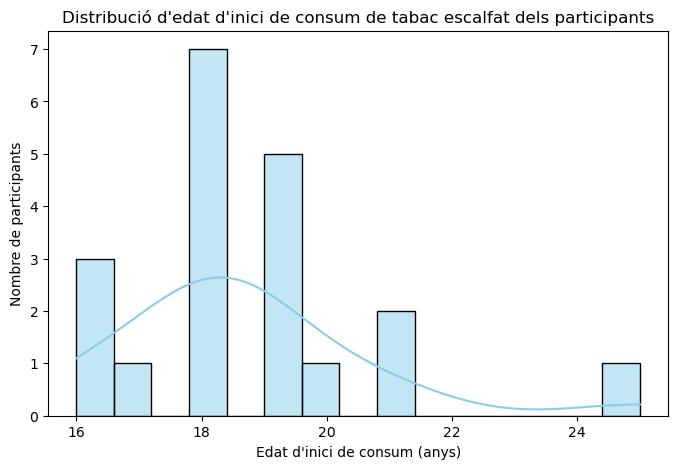

In [24]:
# plot per la distribució d'edat
print(stats.shapiro(df["edat_inici_iqos"].dropna()))
plt.figure(figsize=(8, 5))
sns.histplot(df["edat_inici_iqos"].dropna(), bins=15, kde=True, color="skyblue")
plt.title("Distribució d'edat d'inici de consum de tabac escalfat dels participants")
plt.xlabel("Edat d'inici de consum (anys)")
plt.ylabel("Nombre de participants")
plt.show()



ShapiroResult(statistic=0.8977273979659482, pvalue=6.958612050409679e-06)


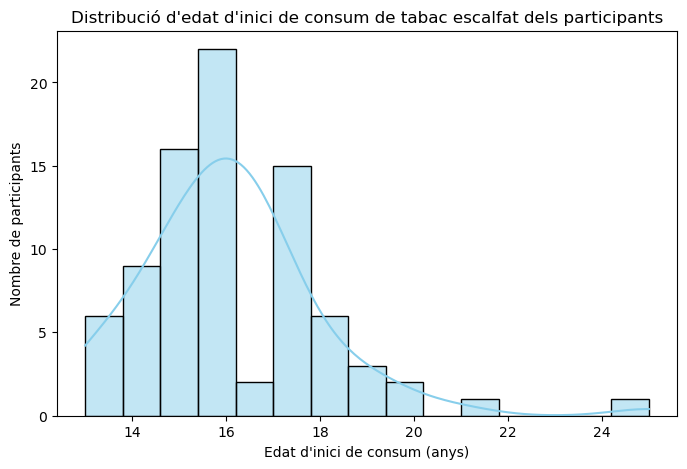

In [25]:
# plot per la distribució d'edat
print(stats.shapiro(df["edat_inici_conventional"].dropna()))
plt.figure(figsize=(8, 5))
sns.histplot(df["edat_inici_conventional"].dropna(), bins=15, kde=True, color="skyblue")
plt.title("Distribució d'edat d'inici de consum de tabac escalfat dels participants")
plt.xlabel("Edat d'inici de consum (anys)")
plt.ylabel("Nombre de participants")
plt.show()

ShapiroResult(statistic=0.854714676198343, pvalue=2.080861312385029e-05)


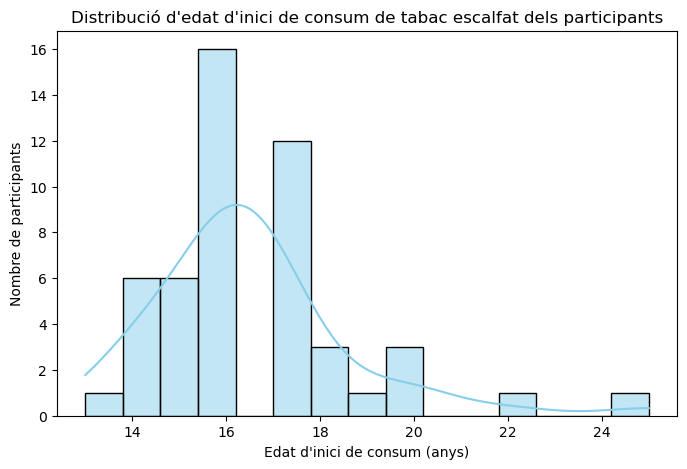

In [26]:
# plot per la distribució d'edat
print(stats.shapiro(df["edat_inici_vaper"].dropna()))
plt.figure(figsize=(8, 5))
sns.histplot(df["edat_inici_vaper"].dropna(), bins=15, kde=True, color="skyblue")
plt.title("Distribució d'edat d'inici de consum de tabac escalfat dels participants")
plt.xlabel("Edat d'inici de consum (anys)")
plt.ylabel("Nombre de participants")
plt.show()

In [27]:
variables = ["edat_inici_vaper", "edat_inici_iqos", "edat_inici_conventional"]

for var in variables:
    Q1 = df[var].quantile(0.25)
    mediana = df[var].median()
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    print(f"\n📌 {var.upper()}")
    print(f"  Q1 (25%): {Q1:.2f}")
    print(f"  Mediana: {mediana:.2f}")
    print(f"  Q3 (75%): {Q3:.2f}")
    print(f"  RIC/IQR: {IQR:.2f}")


📌 EDAT_INICI_VAPER
  Q1 (25%): 15.25
  Mediana: 16.00
  Q3 (75%): 17.00
  RIC/IQR: 1.75

📌 EDAT_INICI_IQOS
  Q1 (25%): 18.00
  Mediana: 18.00
  Q3 (75%): 19.00
  RIC/IQR: 1.00

📌 EDAT_INICI_CONVENTIONAL
  Q1 (25%): 15.00
  Mediana: 16.00
  Q3 (75%): 17.00
  RIC/IQR: 2.00


In [28]:
def tabla_multirespuesta(df, columna):
    # 1. Limpiar columna y convertir en listas
    df[columna] = df[columna].fillna("").astype(str)
    df[columna + "_list"] = df[columna].str.split(";")

    # Limpieza + normalización (lowercase)
    df[columna + "_list"] = df[columna + "_list"].apply(
        lambda x: [s.strip().lower() for s in x if s.strip() != ""]
    )

    # 2. Filtrar filas con alguna respuesta
    df_valid = df[df[columna + "_list"].apply(len) > 0]

    # 3. Explode
    df_exploded = df_valid.explode(columna + "_list")

    # 4. EXCLUIR "no consumeixo"
    df_exploded = df_exploded[df_exploded[columna + "_list"] != "no consumeixo"]

    # 5. Nuevo total de personas que han contestado algo REAL
    total_personas_reales = df_exploded.index.nunique()
    print(f"Total personas con motivos reales en '{columna}': {total_personas_reales}")
    # 6. Tabla n + % SOLO con motivos reales
    tabla = df_exploded[columna + "_list"].value_counts().reset_index()
    tabla.columns = ["Categoria", "n"]

    tabla["%"] = round((tabla["n"] / total_personas_reales) * 100, 2)

    return tabla



tabla_motiu_vaper = tabla_multirespuesta(df, "motiu_inici_vaper")
tabla_motiu_iqos = tabla_multirespuesta(df, "motiu_inici_iqos")

tabla_motiu_vaper


Total personas con motivos reales en 'motiu_inici_vaper': 51
Total personas con motivos reales en 'motiu_inici_iqos': 19


,Categoria,n,%
0,per curiositat,38,74.51
1,pel sabor o l’olor,27,52.94
2,perquè ho fan els amics,9,17.65
3,per reduir l’estrès,4,7.84
4,perquè crec que és més sa / menys nociu,4,7.84
5,de festa,4,7.84
6,era lo que conseguia,1,1.96
7,perquè és més barat,1,1.96
8,per deixar de fumar tabac convencional,1,1.96


In [29]:
tabla_motiu_iqos

,Categoria,n,%
0,per curiositat,10,52.63
1,pel sabor o l’olor,6,31.58
2,per deixar de fumar tabac convencional,5,26.32
3,perquè crec que és més sa / menys nociu,5,26.32
4,perquè ho fan els amics,3,15.79
5,per reduir l’estrès,1,5.26
6,de festa,1,5.26


In [30]:
likert_columns_ambiguas = ['likert_social', 'likert_normal_vapejar', 'likert_menys_perjudicials', 'likert_pocs_estudis']
likert_columnas_no_ambiguas = [col for col in likert_columns if col not in likert_columns_ambiguas]
likert_ambiguas = df[likert_columns_ambiguas]
likert_no_ambiguas = df[likert_columnas_no_ambiguas]

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# ================================
# 0) CREAR EL NOU GRUP DE CONSUM 30 DIES
# ================================
df["grup_consum30"] = np.where(
    (df["consum_Cigarretes electròniques"] == 1) | 
    (df["consum_Tabac convencional"] == 1) |
    (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1),
    1, 0
)

print(df["grup_consum30"].value_counts())


# ================================
# 1) ÍTEMS QUE S’HAN D’INVERTIR
# ================================
invert_items = [
    'likert_seguretat',
    'likert_menys_perjudicials',
    'likert_no_afecta_tercers'
]

for col in invert_items:
    df[col] = df[col].apply(lambda x: 6 - x if pd.notna(x) else np.nan)


# ================================
# 2) DEFINIR DIMENSIONS
# ================================
dimensions = {
    "Accessibility": ['likert_facil_adquirir', 'likert_preu_assequible'],
    "Acceptability": ['likert_normal_vapejar'],  
    "Safety": ['likert_seguretat', 'likert_no_afecta_tercers'],
    "Supervision": ['likert_limit_menors', 'likert_control_estricte',
                    'likert_regulacio_sabors', 'likert_prohibicio_espais_tancats'],
    "Restriction": ['likert_prohibicio_publicitat', 'likert_punts_autoritzats',
                    'likert_advertencies', 'likert_electronic_induccio_tabac']
}

# ================================
# 3) CALCULAR MITJANES DE DIMENSIONS
# ================================
for dim, cols in dimensions.items():
    df[f"{dim}_mean"] = df[cols].mean(axis=1)


# ================================
# 4) FUNCIÓ DE COMPARACIÓ ENTRE GRUPS
# ================================
def compare_groups(variable):
    sub = df[[variable, "grup_consum30"]].dropna()
    g0 = sub[sub["grup_consum30"] == 0][variable]  # NO consum
    g1 = sub[sub["grup_consum30"] == 1][variable]  # SÍ consum

    # normalitat
    p0 = shapiro(g0)[1] if len(g0) > 3 else 0
    p1 = shapiro(g1)[1] if len(g1) > 3 else 0
    normal = (p0 > 0.05) and (p1 > 0.05)

    if normal:
        test_stat, p = ttest_ind(g0, g1, equal_var=False)
    else:
        test_stat, p = mannwhitneyu(g0, g1, alternative="two-sided")

    return test_stat, p, g0.mean(), g0.std(), g1.mean(), g1.std()


# ================================
# 5) GENERAR TAULA FINAL
# ================================
rows = []

for dim in dimensions.keys():
    t, p, mean_non, sd_non, mean_yes, sd_yes = compare_groups(f"{dim}_mean")
    total_mean = df[f"{dim}_mean"].mean()
    total_sd = df[f"{dim}_mean"].std()

    rows.append({
        "Dimension": dim,
        "Total Mean (SD)": f"{total_mean:.2f} ({total_sd:.2f})",
        "No consumption Mean (SD)": f"{mean_non:.2f} ({sd_non:.2f})",
        "Consumption Mean (SD)": f"{mean_yes:.2f} ({sd_yes:.2f})",
        "t/U": f"{t:.3f}",
        "p-value": f"{p:.3f}"
    })
# ================================
# 6) AFEGIR FILA TOTAL (mitjana de totes les dimensions)
# ================================

# calcular la mitjana global (promig de les dimensions individuals)
dimension_columns = [f"{dim}_mean" for dim in dimensions.keys()]
df["Total_mean"] = df[dimension_columns].mean(axis=1)

# comparació entre grups
t_tot, p_tot, mean_non_tot, sd_non_tot, mean_yes_tot, sd_yes_tot = compare_groups("Total_mean")

rows.append({
    "Dimension": "TOTAL",
    "Total Mean (SD)": f"{df['Total_mean'].mean():.2f} ({df['Total_mean'].std():.2f})",
    "No consumption Mean (SD)": f"{mean_non_tot:.2f} ({sd_non_tot:.2f})",
    "Consumption Mean (SD)": f"{mean_yes_tot:.2f} ({sd_yes_tot:.2f})",
    "t/U": f"{t_tot:.3f}",
    "p-value": f"{p_tot:.3f}"
})

# reconstruir la taula amb la fila total afegida
likert_table = pd.DataFrame(rows)
display(likert_table)



grup_consum30
0    354
1     71
Name: count, dtype: int64


,Dimension,Total Mean (SD),No consumption Mean (SD),Consumption Mean (SD),t/U,p-value
0,Accessibility,4.13 (0.63),4.12 (0.63),4.18 (0.64),11743.000,0.370
1,Acceptability,3.02 (1.19),2.97 (1.16),3.27 (1.28),10809.000,0.055
2,Safety,4.45 (0.55),4.47 (0.54),4.38 (0.62),13419.000,0.344
3,Supervision,4.49 (0.54),4.53 (0.47),4.30 (0.78),14625.500,0.025
4,Restriction,4.51 (0.47),4.52 (0.47),4.50 (0.50),12621.000,0.954
5,TOTAL,4.12 (0.37),4.12 (0.37),4.12 (0.40),12169.000,0.674


In [32]:
# correlation matrix between the group of variables 1 which is ["edat", "sexe", "curs", "assignacio_mensual"] and the likert dimensions

variables_group1 = ["edat", "sexe_assignat", "curs", "assignacio_mensual"]
variables_group2 = [f"{dim}_mean" for dim in dimensions.keys()]
resultados_corr = []
for var1 in variables_group1:
    for var2 in variables_group2:
        sub = df[[var1, var2]].dropna()
        if len(sub) < 3:
            r, p = np.nan, np.nan
        else:
            r, p = pearsonr(sub[var1], sub[var2])
        resultados_corr.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Correlation r": r,
            "p-value": p
        })
corr_df = pd.DataFrame(resultados_corr)
corr_df = corr_df.sort_values("p-value")
print("📌 MATRIZ DE CORRELACIONES ENTRE VARIABLES CUANTITATIVAS Y DIMENSIONES LIKERT")
display(corr_df)


📌 MATRIZ DE CORRELACIONES ENTRE VARIABLES CUANTITATIVAS Y DIMENSIONES LIKERT


,Variable 1,Variable 2,Correlation r,p-value
14,curs,Restriction_mean,0.158772,0.001022
13,curs,Supervision_mean,0.150645,0.001844
1,edat,Acceptability_mean,-0.131452,0.006652
11,curs,Acceptability_mean,-0.120492,0.012928
6,sexe_assignat,Acceptability_mean,0.088742,0.067597
17,assignacio_mensual,Safety_mean,-0.085113,0.085585
12,curs,Safety_mean,0.071949,0.138656
0,edat,Accessibility_mean,-0.066511,0.171112
9,sexe_assignat,Restriction_mean,0.062124,0.201188
3,edat,Supervision_mean,0.051558,0.288934


In [33]:
df["amics_fumen"].value_counts()

amics_fumen
Cap                346
Només una           63
Sí, totes dues      16
Name: count, dtype: int64

In [34]:
mapping_amics = {
    "Cap": 0,
    "Només una ": 1,
    "Sí, totes dues ": 2
}

df["amics_fumen_num"] = df["amics_fumen"].map(mapping_amics)


In [35]:
counts = df["amics_fumen_num"].value_counts().sort_index()
percent = df["amics_fumen_num"].value_counts(normalize=True).sort_index() * 100

print("n per categoria:")
print(counts)

print("\nPercentatges:")
print(percent.round(1))


n per categoria:
amics_fumen_num
0    346
1     63
2     16
Name: count, dtype: int64

Percentatges:
amics_fumen_num
0    81.4
1    14.8
2     3.8
Name: proportion, dtype: float64


In [36]:
# correlacion entre amics que fumen i fumador/exfumador/no fumador
resultados = []
for col in ["fumador", "exfumador", "no_fumador"]:
    datos = df[[col, "amics_fumen_num"]].dropna()

    if len(datos) < 3:
        r = np.nan
        p = np.nan
    else:
        r, p = pearsonr(datos[col], datos["amics_fumen_num"])

    resultados.append({
        "variable_fumador": col,
        "correlacion_r": r,
        "p_valor": p
    })
tabla_cor_amics = pd.DataFrame(resultados).round(4)
tabla_cor_amics.sort_values("p_valor")

,variable_fumador,correlacion_r,p_valor
0,fumador,0.1721,0.0004
2,no_fumador,-0.1424,0.0033
1,exfumador,0.0554,0.2548


In [37]:
# CORRELACION ENTRE coneix_diferencia_iqos_vaper Y fumador/exfumador/no fumador
resultados = []

for col in ["fumador", "exfumador", "no_fumador"]:
    datos = df[[col, "coneix_diferencia_iqos_vaper"]].dropna()

    if len(datos) < 3:
        r = np.nan
        p = np.nan
    else:
        r, p = pearsonr(datos[col], datos["coneix_diferencia_iqos_vaper"])

    resultados.append({
        "variable_fumador": col,
        "correlacion_r": r,
        "p_valor": p
    })
tabla_cor_iqos_fumador = pd.DataFrame(resultados).round(4)
tabla_cor_iqos_fumador.sort_values("p_valor")


,variable_fumador,correlacion_r,p_valor
2,no_fumador,-0.1507,0.0018
0,fumador,0.1436,0.0030
1,exfumador,0.0816,0.0931


In [38]:
# n y % de respuestas de la categoria coneix_diferencia_iqos_vaper
counts = df["coneix_diferencia_iqos_vaper"].value_counts().sort_index()
percent = df["coneix_diferencia_iqos_vaper"].value_counts(normalize=True).sort_index() * 100
print("n per categoria:")
print(counts)
print("\nPercentatges:")
print(percent.round(1))


n per categoria:
coneix_diferencia_iqos_vaper
0    245
1    180
Name: count, dtype: int64

Percentatges:
coneix_diferencia_iqos_vaper
0    57.6
1    42.4
Name: proportion, dtype: float64


In [39]:
# CORRELACION ENTRE coneix_diferencia_iqos_vaper Y categorias likert
resultados = []
for col in likert_columns:
    datos = df[[col, "coneix_diferencia_iqos_vaper"]].dropna()

    if len(datos) < 3:
        r = np.nan
        p = np.nan
    else:
        r, p = pearsonr(datos[col], datos["coneix_diferencia_iqos_vaper"])

    resultados.append({
        "likert": col,
        "correlacion_r": r,
        "p_valor": p
    })
tabla_cor_iqos_likert = pd.DataFrame(resultados).round(4)
tabla_cor_iqos_likert.sort_values("p_valor")



,likert,correlacion_r,p_valor
11,likert_prohibicio_espais_tancats,-0.1251,0.0098
0,likert_facil_adquirir,0.1189,0.0142
1,likert_preu_assequible,0.1118,0.0211
15,likert_electronic_induccio_tabac,0.1033,0.0333
3,likert_normal_vapejar,0.0787,0.1050
2,likert_social,-0.0670,0.1681
10,likert_regulacio_sabors,0.0422,0.3856
7,likert_no_afecta_tercers,-0.0356,0.4641
5,likert_menys_perjudicials,0.0254,0.6012
8,likert_limit_menors,-0.0210,0.6652


In [40]:
# from all the people that has a 1 on the coneix_diferencia_iqos_vaper, how many are fumador, exfumador and no_fumador and % of them
df_iqos_coneix = df[df["coneix_diferencia_iqos_vaper"] == 1]
estado_fumador_iqos = {
    "Fumador": df_iqos_coneix["fumador"].sum(),
    "Exfumador": df_iqos_coneix["exfumador"].sum(),
    "No fumador": df_iqos_coneix["no_fumador"].sum()
}
estado_fumador_iqos_df = pd.DataFrame.from_dict(estado_fumador_iqos, orient="index", columns=["n"])
estado_fumador_iqos_df["%"] = (estado_fumador_iqos_df["n"] / len(df_iqos_coneix) * 100).round(1).astype(str) + "%"
print("Estado de fumador entre los participantes que conocen la diferencia IQOS/Vaper:")
display(estado_fumador_iqos_df)

Estado de fumador entre los participantes que conocen la diferencia IQOS/Vaper:


,n,%
Fumador,16,8.9%
Exfumador,36,20.0%
No fumador,128,71.1%


In [41]:
# exportar df a un excel
df.to_excel("dataframe_completo.xlsx", index=False)

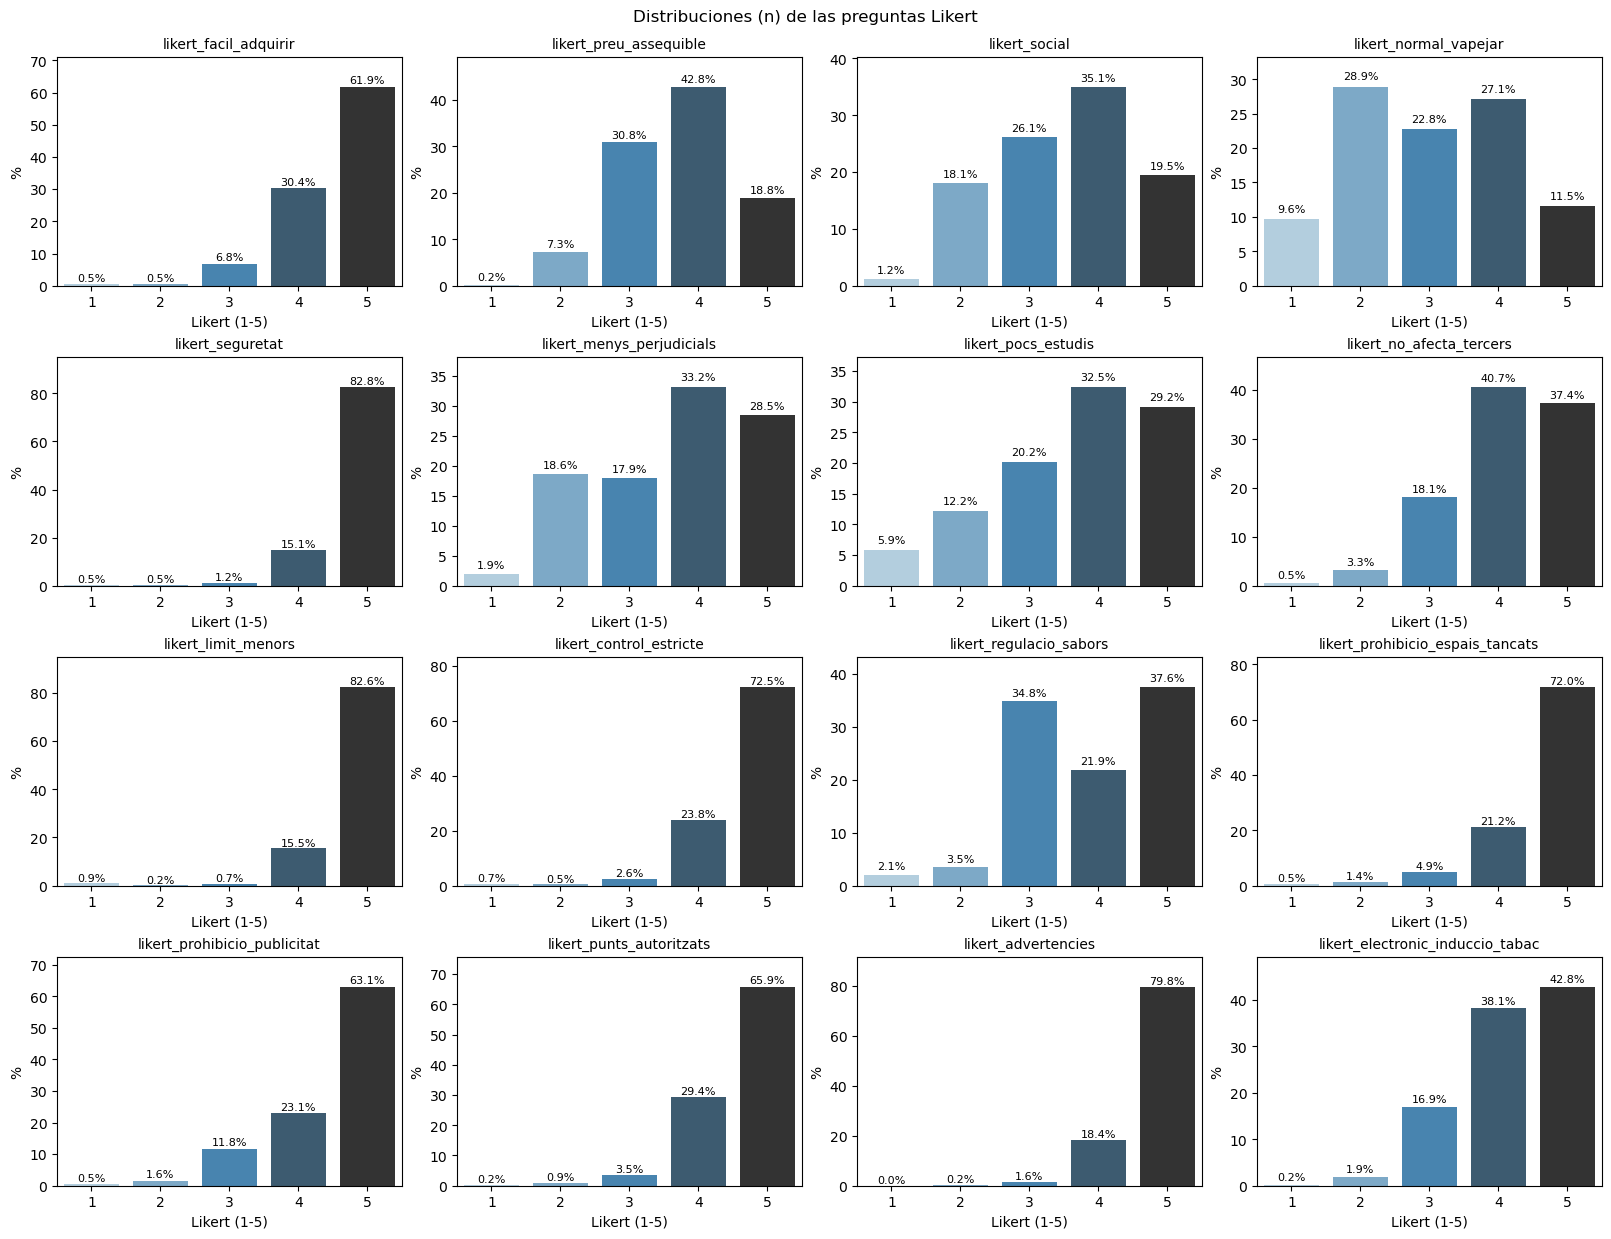

In [42]:
# Plots de barras con distribuciones y tabla resumen (media, mediana, IC 95%) para las columnas Likert
# 
# (counts: cantidades absolutas, perc: porcentaje respecto al total de respuestas válidas)


n_cols = 4
n_rows = int(np.ceil(len(likert_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), constrained_layout=True)
axes = axes.flatten()

summary_rows = []
for i, col in enumerate(likert_columns):
    ax = axes[i]
    # Asegurar serie numérica y filtrar NaNs
    series = pd.to_numeric(df[col], errors="coerce").dropna().astype(int)
    counts = series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
    perc = counts / counts.sum() * 100

    # Barplot de porcentajes por categoría (1..5)
    sns.barplot(
        x=perc.index,
        y=perc.values,
        hue=perc.index,
        palette="Blues_d",
        ax=ax,
        legend=False
    )
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("Likert (1-5)")
    ax.set_ylabel("%")
    ax.set_ylim(0, max(perc.values.max() * 1.15, 1))

    # Anotar porcentajes encima de cada barra
    for xi, val in enumerate(perc.values):
        ax.text(xi, val + 1.0, f"{val:.1f}%", ha="center", fontsize=8)

    # Estadísticos: n, media, mediana, IC 95% (t-student)
    n = int(series.count())
    mean = float(series.mean()) if n > 0 else np.nan
    median = float(series.median()) if n > 0 else np.nan

    if n > 1:
        se = stats.sem(series, nan_policy="omit")
        h = se * stats.t.ppf((1 + 0.95) / 2., n - 1)
        ci_low = mean - h
        ci_high = mean + h
    else:
        ci_low = np.nan
        ci_high = np.nan

    summary_rows.append({
        "column": col,
        "n": n,
        "mean": mean,
        "median": median,
        "ci95_low": ci_low,
        "ci95_high": ci_high
    })

# Quitar ejes sobrantes si los hubiera
for j in range(len(likert_columns), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribuciones (n) de las preguntas Likert", y=1.02)
plt.show()

In [43]:
# Crear una copia de summary_df pero con el índice renombrado a las preguntas originales
# Invertir el mapeo original para recuperar las preguntas tal como estaban antes del rename
invert_map = {v: k for k, v in column_map.items()}

# Construir la tabla resumen
summary_df = pd.DataFrame(summary_rows).set_index("column")
summary_df = summary_df[["n", "mean", "median", "ci95_low", "ci95_high"]]

# Formateo para mostrar
summary_df = summary_df.round({"mean": 2, "median": 2, "ci95_low": 2, "ci95_high": 2})

# Copiar summary_df y reemplazar índices (nombres de columna renombrados) por la pregunta original
summary_df_preguntas = summary_df.copy()
summary_df_preguntas.index = [invert_map.get(idx, idx) for idx in summary_df_preguntas.index]
summary_df_preguntas.index.name = "pregunta"

# addition of standard deviation column
summary_df_preguntas["std_dev"] = df[likert_columns].std().values



display(summary_df_preguntas)

,n,mean,median,ci95_low,ci95_high,std_dev
pregunta,,,,,,
Les cigarretes electròniques són fàcils d’adquirir.,425,4.53,5.0,4.46,4.59,0.686698
El seu preu és assequible per a la majoria dels joves.,425,3.73,4.0,3.65,3.81,0.858282
Vapejar està socialment ben vist.,425,3.54,4.0,3.44,3.64,1.036691
Considero que és normal veure companys vapejant en espais universitaris o socials.,425,3.02,3.0,2.91,3.13,1.187444
Crec que les cigarretes electròniques són segures per a la salut.,425,4.79,5.0,4.74,4.84,0.522555
Les considero menys perjudicials que el tabac convencional.,425,3.68,4.0,3.57,3.79,1.129407
No hi ha prou estudis sobre els efectes adversos del vaping.,425,3.67,4.0,3.56,3.78,1.185825
El vapor de les cigarretes electròniques no afecta a tercers.,425,4.11,4.0,4.03,4.19,0.847553
S’hauria de limitar l’accés a menors.,425,4.79,5.0,4.73,4.84,0.556936


In [44]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# ============================================================
# 0. VARIABLE DEPENDIENTE: consumo en los últimos 30 días
# ============================================================

df["grup_consum30"] = np.where(
    (df["consum_Cigarretes electròniques"] == 1) | 
    (df["consum_Tabac convencional"] == 1) |
    (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1),
    1, 0
)

print("Distribución de consumo 30 días:")
print(df["grup_consum30"].value_counts())


# ============================================================
# 1. PREDICTORES DEL MODELO COMPLETO
# ============================================================

predictors = [
    "edat",
    "sexe_assignat",
    "curs",
    "assignacio_mensual",
    "Accessibility_mean",
    "Acceptability_mean",
    "Safety_mean",
    "Supervision_mean",
    "Restriction_mean"
]


# ============================================================
# 2. AJUSTAR MODELO LOGIT COMPLETO
# ============================================================

formula = "grup_consum30 ~ " + " + ".join(predictors)
print("\n📌 Fórmula logística usada:")
print(formula)

df_model = df[["grup_consum30"] + predictors].dropna()

logit_model = smf.logit(formula, data=df_model).fit()
print(logit_model.summary())


# ============================================================
# 3. TABLA DE AOR + IC95%
# ============================================================

params = logit_model.params
conf = logit_model.conf_int()

or_table = pd.DataFrame({
    "AOR": np.exp(params),
    "IC95_inf": np.exp(conf[0]),
    "IC95_sup": np.exp(conf[1]),
    "p_valor": logit_model.pvalues
})

print("\n📌 ODDS RATIOS AJUSTADOS (AOR) + IC95%")
display(or_table.round(4))


# ============================================================
# 4. MULTICOLINEALIDAD (VIF)
# ============================================================

print("\n📌 VIF (Multicolinealidad) del modelo completo:")

X = df_model[predictors]
X = sm.add_constant(X)

vif_df = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

display(vif_df)


Distribución de consumo 30 días:
grup_consum30
0    354
1     71
Name: count, dtype: int64

📌 Fórmula logística usada:
grup_consum30 ~ edat + sexe_assignat + curs + assignacio_mensual + Accessibility_mean + Acceptability_mean + Safety_mean + Supervision_mean + Restriction_mean
Optimization terminated successfully.
         Current function value: 0.414870
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          grup_consum30   No. Observations:                  409
Model:                          Logit   Df Residuals:                      399
Method:                           MLE   Df Model:                            9
Date:                Sat, 27 Dec 2025   Pseudo R-squ.:                 0.06124
Time:                        00:41:46   Log-Likelihood:                -169.68
converged:                       True   LL-Null:                       -180.75
Covariance Type:            nonrobust   LLR p-value:               

,AOR,IC95_inf,IC95_sup,p_valor
Intercept,3.7814,0.0374,382.3345,0.5723
edat,0.8593,0.7329,1.0076,0.0619
sexe_assignat,1.2147,0.6508,2.2672,0.5413
curs,1.1487,0.9270,1.4234,0.2050
assignacio_mensual,1.0006,1.0000,1.0012,0.0581
Accessibility_mean,1.3693,0.8609,2.1781,0.1844
Acceptability_mean,1.1244,0.8902,1.4201,0.3251
Safety_mean,1.0569,0.6205,1.8003,0.8387
Supervision_mean,0.3766,0.2067,0.6863,0.0014
Restriction_mean,1.4892,0.7124,3.1130,0.2899



📌 VIF (Multicolinealidad) del modelo completo:


,Variable,VIF
0,const,229.038564
1,edat,2.080848
2,sexe_assignat,1.027115
3,curs,1.600487
4,assignacio_mensual,1.456645
5,Accessibility_mean,1.093689
6,Acceptability_mean,1.053114
7,Safety_mean,1.178612
8,Supervision_mean,1.622682
9,Restriction_mean,1.524008


In [45]:
from scipy.stats import pointbiserialr
import pandas as pd
import numpy as np
from IPython.display import HTML, display

# ============================================================
# 1. Likert DIMENSIONS instead of individual items
# ============================================================

dimension_cols = [
    "Accessibility_mean",
    "Acceptability_mean",
    "Safety_mean",
    "Supervision_mean",
    "Restriction_mean",
    # "Total_mean"  # ← activar si quieres incluirla
]

# ============================================================
# 2. Selected consumption columns
# ============================================================

consumption_cols_specific = [
    'consum_Alcohol',
    'consum_Altres',
    'consum_Amfetamines',
    'consum_Cap',
    'consum_Cigarretes electròniques',
    'consum_Cànnabis',
    'consum_Estimulants',
    'consum_Productes de tabac per escalfament (tipus IQOS)',
    'consum_Tabac convencional'
]

# Filtrar solo las que existen realmente en df
consumption_cols_specific = [c for c in consumption_cols_specific if c in df.columns]
print("Variables de consumo analizadas:", consumption_cols_specific)

# ============================================================
# 3. Compute point-biserial correlation between dimensions and consumption
# ============================================================

results = []

for dim in dimension_cols:
    for cons in consumption_cols_specific:

        sub = df[[dim, cons]].dropna()

        # Necesita ser binario 0/1
        if sub[cons].nunique() != 2:
            continue

        r, p = pointbiserialr(sub[cons], sub[dim])

        results.append({
            "Likert dimension": dim,
            "Consumption variable": cons,
            "r (point-biserial)": r,
            "p-value": p,
            "n": len(sub)
        })

correlation_dimensions = pd.DataFrame(results).round(4)

# Ordenar por significancia
correlation_dimensions = correlation_dimensions.sort_values("p-value")

# ============================================================
# 4. Make table scrollable
# ============================================================

def make_scrollable(df, height=300):
    return HTML(f'''
    <div style="height:{height}px; overflow-y:scroll; border:1px solid #ccc;">
        {df.to_html()}
    </div>
    ''')

display(make_scrollable(correlation_dimensions, height=400))


Variables de consumo analizadas: ['consum_Alcohol', 'consum_Altres', 'consum_Amfetamines', 'consum_Cap', 'consum_Cigarretes electròniques', 'consum_Cànnabis', 'consum_Estimulants', 'consum_Productes de tabac per escalfament (tipus IQOS)', 'consum_Tabac convencional']


,Likert dimension,Consumption variable,r (point-biserial),p-value,n
35,Supervision_mean,consum_Tabac convencional,-0.1567,0.0012,425
31,Supervision_mean,consum_Cigarretes electròniques,-0.1271,0.0087,425
30,Supervision_mean,consum_Cap,0.1113,0.0217,425
17,Acceptability_mean,consum_Tabac convencional,0.1084,0.0255,425
27,Supervision_mean,consum_Alcohol,-0.1055,0.0297,425
33,Supervision_mean,consum_Estimulants,-0.0950,0.0504,425
13,Acceptability_mean,consum_Cigarretes electròniques,0.0871,0.0729,425
34,Supervision_mean,consum_Productes de tabac per escalfament (tipus IQOS),-0.0801,0.0993,425
21,Safety_mean,consum_Cap,0.0755,0.1202,425
42,Restriction_mean,consum_Estimulants,-0.0746,0.1244,425


In [46]:
# cuantas personas han probado el tabaco, el iqos y el vaper a la vez y en que orden las han probado
df_fumadores_identificados = df[
    (df["consum_Cigarretes electròniques"] == 1) &
    (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1) &
    (df["consum_Tabac convencional"] == 1)
]
num_fumadores_identificados = len(df_fumadores_identificados)
print(f"Número de personas que han probado tabaco convencional, IQOS y vaper: {num_fumadores_identificados}")

orden_prueba = {
    "Tabac convencional → IQOS → Vaper": 0,
    "Tabac convencional → Vaper → IQOS": 0,
    "IQOS → Tabac convencional → Vaper": 0,
    "IQOS → Vaper → Tabac convencional": 0,
    "Vaper → Tabac convencional → IQOS": 0,
    "Vaper → IQOS → Tabac convencional": 0
}
for _, row in df_fumadores_identificados.iterrows():
    edat_tabac = row["edat_inici_conventional"]
    edat_iqos = row["edat_inici_iqos"]
    edat_vaper = row["edat_inici_vaper"]

    if edat_tabac < edat_iqos < edat_vaper:
        orden_prueba["Tabac convencional → IQOS → Vaper"] += 1
    elif edat_tabac < edat_vaper < edat_iqos:
        orden_prueba["Tabac convencional → Vaper → IQOS"] += 1
    elif edat_iqos < edat_tabac < edat_vaper:
        orden_prueba["IQOS → Tabac convencional → Vaper"] += 1
    elif edat_iqos < edat_vaper < edat_tabac:
        orden_prueba["IQOS → Vaper → Tabac convencional"] += 1
    elif edat_vaper < edat_tabac < edat_iqos:
        orden_prueba["Vaper → Tabac convencional → IQOS"] += 1
    elif edat_vaper < edat_iqos < edat_tabac:
        orden_prueba["Vaper → IQOS → Tabac convencional"] += 1
        

Número de personas que han probado tabaco convencional, IQOS y vaper: 10


In [47]:
#Personas que han probado los 3 productos teniendo en cuenta las columnas de las edades de inicio
df_fumadores_identificados = df[
    df[["edat_inici_conventional", "edat_inici_iqos", "edat_inici_vaper"]].notna().all(axis=1)
]
# Filtrar las filas donde las tres columnas no son NaN
df_fumadores_identificados = df_fumadores_identificados[
    (df_fumadores_identificados["edat_inici_conventional"] > 0) &
    (df_fumadores_identificados["edat_inici_iqos"] > 0) &
    (df_fumadores_identificados["edat_inici_vaper"] > 0)
]
# Seleccionar solo las columnas de edades de inicio
df_edades = df_fumadores_identificados[
    ["edat_inici_conventional", "edat_inici_iqos", "edat_inici_vaper"]
].copy()

# Función para ordenar por edad de inicio
def ordenar_inicios(row):
    edades = {
        "conventional": row["edat_inici_conventional"],
        "iqos": row["edat_inici_iqos"],
        "vaper": row["edat_inici_vaper"]
    }
    # Ordenar por edad de menor a mayor
    orden = sorted(edades, key=edades.get)
    return orden

# Crear nueva columna con el orden probado
df_edades["orden_probad"] = df_edades.apply(ordenar_inicios, axis=1)

df_edades.head()
df_edades["orden_probad"].value_counts()



orden_probad
[conventional, vaper, iqos]    8
[vaper, conventional, iqos]    4
[conventional, iqos, vaper]    2
Name: count, dtype: int64

In [48]:
cols_edades = [
    "edat_inici_conventional",
    "edat_inici_iqos",
    "edat_inici_vaper"
]

# Contar cuántos productos tienen edad válida
df["n_productos_validos"] = (df[cols_edades] > 0).sum(axis=1)

# Filtrar personas con al menos 2 productos
df_fumadores_identificados = df[df["n_productos_validos"] >= 2]

df_edades = df_fumadores_identificados[cols_edades].copy()

def ordenar_inicios(row):
    edades = {
        "conventional": row["edat_inici_conventional"],
        "iqos": row["edat_inici_iqos"],
        "vaper": row["edat_inici_vaper"]
    }
    
    # Quedarse solo con productos con edad válida
    edades_validas = {k: v for k, v in edades.items() if v > 0}
    
    # Ordenar por edad
    orden = sorted(edades_validas, key=edades_validas.get)
    return orden


In [49]:
df_edades["orden_probad"] = df_edades.apply(ordenar_inicios, axis=1)
df_edades["orden_probad"].value_counts()


orden_probad
[conventional, vaper]          19
[vaper, conventional]           9
[conventional, vaper, iqos]     8
[conventional, iqos]            6
[vaper, conventional, iqos]     4
[conventional, iqos, vaper]     2
Name: count, dtype: int64

In [50]:
df_vaper = df[df["edat_inici_vaper"] > 0].copy()
def tabaco_antes_vaper(row):
    if row["edat_inici_conventional"] > 0:
        if row["edat_inici_conventional"] < row["edat_inici_vaper"]:
            return "Tabaco antes"
        elif row["edat_inici_conventional"] > row["edat_inici_vaper"]:
            return "Vaper antes"
        else:
            return "Mismo inicio"
    else:
        return "Sin tabaco previo"
df_vaper["orden_tabaco_vaper"] = df_vaper.apply(tabaco_antes_vaper, axis=1)
df_vaper["tabaco_antes"] = df_vaper["orden_tabaco_vaper"] == "Tabaco antes"

df_vaper["tabaco_antes"].value_counts()
df_vaper["orden_tabaco_vaper"].value_counts()


orden_tabaco_vaper
Tabaco antes         15
Mismo inicio         14
Vaper antes          13
Sin tabaco previo     8
Name: count, dtype: int64

In [51]:
#personas en total que han probado vaper
total_vaper = len(df[df["edat_inici_vaper"] > 0])
print(f"Número total de personas que han probado vaper: {total_vaper}")


Número total de personas que han probado vaper: 50


***AÑADIDO LA MADRUGADA DEL 27 DE DICIEMBRE***

In [57]:
#correlacion entre likert y haber probado tabaco, vaper o iqos
resultats_corr = []
for dim in likert_columns:
    for cons in consumption_cols_specific:
        sub = df[[dim, cons]].dropna()
        if sub[cons].nunique() != 2:
            continue
        r, p = pointbiserialr(sub[cons], sub[dim])
        resultats_corr.append({
            "Likert dimension": dim,
            "Consumption variable": cons,
            "r (point-biserial)": r,
            "p-value": p,
            "n": len(sub)
        })
correlation_dimensions = pd.DataFrame(resultats_corr).round(4)
correlation_dimensions = correlation_dimensions.sort_values("p-value")
print("📌 CORRELACIÓN ENTRE DIMENSIONES LIKERT Y CONSUMO DE PRODUCTOS (r punto-biserial)")
display(correlation_dimensions)


📌 CORRELACIÓN ENTRE DIMENSIONES LIKERT Y CONSUMO DE PRODUCTOS (r punto-biserial)


,Likert dimension,Consumption variable,r (point-biserial),p-value,n
103,likert_prohibicio_espais_tancats,consum_Cigarretes electròniques,-0.2955,0.0000,425
106,likert_prohibicio_espais_tancats,consum_Productes de tabac per escalfament (tip...,-0.2352,0.0000,425
107,likert_prohibicio_espais_tancats,consum_Tabac convencional,-0.2578,0.0000,425
123,likert_punts_autoritzats,consum_Estimulants,-0.1746,0.0003,425
80,likert_limit_menors,consum_Tabac convencional,-0.1635,0.0007,425
...,...,...,...,...,...
24,likert_social,consum_Estimulants,-0.0024,0.9603,425
113,likert_prohibicio_publicitat,consum_Cànnabis,-0.0023,0.9621,425
37,likert_seguretat,consum_Altres,0.0015,0.9758,425
23,likert_social,consum_Cànnabis,0.0014,0.9768,425


In [61]:
from scipy.stats import spearmanr, pointbiserialr
import pandas as pd

resultats_corr = []

for dim in likert_columns:
    for var in ["edat", "curs", "assignacio_mensual"] + consumption_cols_specific + ["sexe_assignat"]:
        
        sub = df[[dim, var]].dropna()
        if len(sub) < 10:
            continue
        
        # Variables dicotómicas → punto-biserial
        if sub[var].nunique() == 2:
            try:
                r, p = pointbiserialr(sub[var], sub[dim])
                test = "Punto-biserial"
            except Exception:
                continue
        
        # Variables ordinales / cuantitativas → Spearman
        else:
            try:
                r, p = spearmanr(sub[dim], sub[var])
                test = "Spearman"
            except Exception:
                continue
        
        resultats_corr.append({
            "Ítem Likert": dim,
            "Variable": var,
            "Test": test,
            "Coeficiente": r,
            "p-value": p,
            "n": len(sub)
        })

correlation_correcta = pd.DataFrame(resultats_corr).round(4)
correlation_correcta = correlation_correcta.sort_values("p-value")

print("📌 ASOCIACIÓN ENTRE ÍTEMS LIKERT Y VARIABLES SOCIODEMOGRÁFICAS / CONSUMO")
correlation_correcta

from IPython.display import display, HTML

display(HTML("""
<div style="max-height:500px; overflow:auto;">
""" + correlation_correcta.to_html(index=False) + """
</div>
"""))


📌 ASOCIACIÓN ENTRE ÍTEMS LIKERT Y VARIABLES SOCIODEMOGRÁFICAS / CONSUMO


Ítem Likert,Variable,Test,Coeficiente,p-value,n
likert_prohibicio_espais_tancats,consum_Productes de tabac per escalfament (tipus IQOS),Punto-biserial,-0.2352,0.0000,425
likert_prohibicio_espais_tancats,consum_Tabac convencional,Punto-biserial,-0.2578,0.0000,425
likert_prohibicio_espais_tancats,consum_Cigarretes electròniques,Punto-biserial,-0.2955,0.0000,425
likert_prohibicio_espais_tancats,curs,Spearman,0.1787,0.0002,425
likert_punts_autoritzats,consum_Estimulants,Punto-biserial,-0.1746,0.0003,425
likert_limit_menors,consum_Tabac convencional,Punto-biserial,-0.1635,0.0007,425
likert_social,sexe_assignat,Punto-biserial,0.1626,0.0008,425
likert_pocs_estudis,consum_Tabac convencional,Punto-biserial,0.1584,0.0010,425
likert_prohibicio_espais_tancats,edat,Spearman,0.1555,0.0013,425
likert_normal_vapejar,edat,Spearman,-0.1353,0.0052,425


La asociación entre los ítems individuales de tipo Likert y las variables sociodemográficas y de consumo se evaluó mediante el coeficiente de correlación de Spearman cuando ambas variables eran ordinales o cuantitativas, y mediante el coeficiente de correlación punto-biserial cuando la variable independiente era dicotómica. En todos los casos se reportó el coeficiente de correlación, el valor de p y el tamaño muestral.

In [59]:

# ============================================================
# 0. VARIABLE DEPENDIENTE: consumo en los últimos 30 días
# ============================================================

df["grup_consum30"] = np.where(
    (df["consum_Cigarretes electròniques"] == 1) | 
    (df["consum_Tabac convencional"] == 1) |
    (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1),
    1, 0
)

print("Distribución de consumo 30 días:")
print(df["grup_consum30"].value_counts())


# ============================================================
# 1. PREDICTORES DEL MODELO COMPLETO
# ============================================================

predictors = [
    "edat",
    "sexe_assignat",
    "curs",
    "assignacio_mensual",
]
predictors += likert_columns

# ============================================================
# 2. AJUSTAR MODELO LOGIT COMPLETO
# ============================================================

formula = "grup_consum30 ~ " + " + ".join(predictors)
print("\n📌 Fórmula logística usada:")
print(formula)

df_model = df[["grup_consum30"] + predictors].dropna()

logit_model = smf.logit(formula, data=df_model).fit()
print(logit_model.summary())


# ============================================================
# 3. TABLA DE AOR + IC95%
# ============================================================

params = logit_model.params
conf = logit_model.conf_int()

or_table = pd.DataFrame({
    "AOR": np.exp(params),
    "IC95_inf": np.exp(conf[0]),
    "IC95_sup": np.exp(conf[1]),
    "p_valor": logit_model.pvalues
})

print("\n📌 ODDS RATIOS AJUSTADOS (AOR) + IC95%")
display(or_table.round(4))


# ============================================================
# 4. MULTICOLINEALIDAD (VIF)
# ============================================================

print("\n📌 VIF (Multicolinealidad) del modelo completo:")

X = df_model[predictors]
X = sm.add_constant(X)

vif_df = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

display(vif_df)


Distribución de consumo 30 días:
grup_consum30
0    354
1     71
Name: count, dtype: int64

📌 Fórmula logística usada:
grup_consum30 ~ edat + sexe_assignat + curs + assignacio_mensual + likert_facil_adquirir + likert_preu_assequible + likert_social + likert_normal_vapejar + likert_seguretat + likert_menys_perjudicials + likert_pocs_estudis + likert_no_afecta_tercers + likert_limit_menors + likert_control_estricte + likert_regulacio_sabors + likert_prohibicio_espais_tancats + likert_prohibicio_publicitat + likert_punts_autoritzats + likert_advertencies + likert_electronic_induccio_tabac
Optimization terminated successfully.
         Current function value: 0.365443
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          grup_consum30   No. Observations:                  409
Model:                          Logit   Df Residuals:                      388
Method:                           MLE   Df Model:                   

,AOR,IC95_inf,IC95_sup,p_valor
Intercept,7.4346,0.0325,1701.4385,0.4692
edat,0.8624,0.7337,1.0137,0.0727
sexe_assignat,1.2195,0.6011,2.4745,0.5825
curs,1.1885,0.9468,1.4920,0.1366
assignacio_mensual,1.0005,0.9998,1.0012,0.1413
likert_facil_adquirir,1.0787,0.6534,1.7810,0.7670
likert_preu_assequible,1.2027,0.8256,1.7520,0.3363
likert_social,0.7642,0.5521,1.0579,0.1051
likert_normal_vapejar,1.2370,0.9372,1.6326,0.1332
likert_seguretat,1.5096,0.7303,3.1205,0.2663



📌 VIF (Multicolinealidad) del modelo completo:


,Variable,VIF
0,const,293.121268
1,edat,2.159897
2,sexe_assignat,1.096516
3,curs,1.687584
4,assignacio_mensual,1.499123
5,likert_facil_adquirir,1.253456
6,likert_preu_assequible,1.232815
7,likert_social,1.234589
8,likert_normal_vapejar,1.184116
9,likert_seguretat,1.264617
